# Bicycle data melbourne analysis

In [82]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from tqdm.notebook import tqdm
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go


In [6]:
rootdir = '../../data/DPC/bicycle_flows/'
visuals = '../docs/visuals/bicycle_flows/'

# Open Site Number Listing file
sites = pd.read_excel(f'{rootdir}/VicRoads_Bike_Site_Number_Listing.xlsx')
sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SITE_ID       93 non-null     int64  
 1   TFM_ID        93 non-null     int64  
 2   STRT_LAT      93 non-null     float64
 3   STRT_LONG     93 non-null     float64
 4   GPS           92 non-null     object 
 5   SITE_NAME     91 non-null     object 
 6   TFM_DESC      93 non-null     object 
 7   BEARING_DESC  93 non-null     object 
 8   DATA_SRC_CD   93 non-null     object 
 9   RGN_SHORT_NM  93 non-null     object 
 10  Comments      75 non-null     object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.1+ KB


In [3]:
sites.describe()

,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG
count,93.000000,93.000000,93.000000,93.000000
mean,18008.935484,57763.236559,-37.832249,144.998457
std,12974.657259,10612.712297,0.112396,0.082142
min,6411.000000,20082.000000,-38.507720,144.736270
25%,7596.000000,59454.000000,-37.832280,144.973640
50%,9999.000000,59477.000000,-37.806770,144.987550
75%,32615.000000,61176.000000,-37.783990,145.028100
max,40005.000000,70011.000000,-37.743220,145.291100


In [7]:
fig = px.scatter_mapbox(sites, lat="STRT_LAT", lon="STRT_LONG", hover_name="SITE_NAME", hover_data=["SITE_ID", "BEARING_DESC"],
                        color_discrete_sequence=["fuchsia"], zoom=9, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html(f'{visuals}Site_Map.html')
fig.show()


## Data validation 

The bicycle data is delivered in a large number of CSV files, without an accompanying data dictionary.  To be sure the same columns are shared by all CSVs, such that they can be appended to a master file, we iterate over them and tally up the unique column combinations.  Ideally, the results will be a single combination of columns with a tally count the length of the number of CSV files.  Let's see!

In [2]:
#rootdir ='../data'
#tally = pd.DataFrame(columns=["count","len"])
#counter = 0
#for subdir, dirs, files in tqdm(os.walk(rootdir)):
#    for file in files:
#        if ('.csv' in file) and ('.zip' not in file):
#            # read in CSV, if it contains records (which at least one doesn't!)
#            file_path = os.path.join(subdir,file)
#            if os.path.getsize(file_path) > 0:
#                df = pd.read_csv(os.path.join(subdir,file))
#                # store list of columns in variable df_columns as a string
#                df_columns = f"{df.columns.to_list()}"
#                # if CSV columns string is in the tally index, increment this
#                if df_columns in tally.index:
#                    tally[tally.index==df_columns] += 1
#                # otherwise add CSV columns string to the tally index
#                else:
#                    tally.loc[df_columns] = 1
#                # increment a counter; athough theoretically this should only sum to the sum of tallys!
#                counter+=1
#
#print(counter)

In [8]:
tally

,count
"['DATA_TYPE', 'TIS_DATA_REQUEST', 'SITE_XN_ROUTE', 'LOC_LEG', 'DATE', 'TIME', 'CLASS', 'LANE', 'SPEED', 'WHEELBASE', 'HEADWAY', 'GAP', 'AXLE', 'AXLE_GROUPING', 'RHO', 'VEHICLE', 'DIRECTION']",13229


## Creating a master dataframe

Now that we know that all of the CSVs share the same column names, we will join the various files together to create a master dataframe to run the analysis on. 

In [118]:
data_years = [2017,2018,2019,2020,2021]
folder_prefix = 'Bicycle_Volume_Speed_'

rootdir = f'../../data/DPC/bicycle_flows'


df = []
for year in tqdm(data_years, unit = 'years'):
    csv_files = []
    for subdir, dirs, files in tqdm(os.walk(f'{rootdir}/{folder_prefix}{year}'),
                                    desc= f"Getting CSV file paths ({year})...",
                                    unit="CSVs",
                                    leave = False):
        for file in files:
            if ('.csv' in file) and ('.zip' not in file):
                # record filepaths of CSVs containing records
                file_path = os.path.join(subdir,file)
                # let's make sure we only join files that contain data
                if os.path.getsize(file_path) > 0:
                    csv_files.append(os.path.join(subdir,file))
    dfs=[]
    for csv in tqdm(csv_files,desc=f"Reading csv files for {year}...",unit="CSVs", leave = False):
        dfs.append(pd.read_csv(csv, index_col=None, header=0))

    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    dfs['month_year'] = pd.to_datetime(dfs['DATE'],format='%d/%m/%Y').dt.to_period('M')
    df.append(dfs[dfs.month_year.dt.year==year]\
              .groupby(['SITE_XN_ROUTE', 'LOC_LEG','month_year'])[['VEHICLE', 'SPEED','HEADWAY']]\
              .agg({'VEHICLE': 'count',
                    'SPEED': 'mean',
                    'HEADWAY': 'mean'}).reset_index())
    del dfs

df = pd.concat(df, axis=0, ignore_index=True)

print(f"Identified the locations of {len(csv_files)} valid CSV files to compile!")

  0%|          | 0/5 [00:00<?, ?years/s]

Getting CSV file paths (2017)...: 0CSVs [00:00, ?CSVs/s]

Reading csv files for 2017...:   0%|          | 0/1430 [00:00<?, ?CSVs/s]

C:\Users\carol\AppData\Local\Temp/ipykernel_4820/3820936274.py:27: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Getting CSV file paths (2018)...: 0CSVs [00:00, ?CSVs/s]

Reading csv files for 2018...:   0%|          | 0/1574 [00:00<?, ?CSVs/s]

Getting CSV file paths (2019)...: 0CSVs [00:00, ?CSVs/s]

Reading csv files for 2019...:   0%|          | 0/1685 [00:00<?, ?CSVs/s]

Getting CSV file paths (2020)...: 0CSVs [00:00, ?CSVs/s]

Reading csv files for 2020...:   0%|          | 0/4766 [00:00<?, ?CSVs/s]

Getting CSV file paths (2021)...: 0CSVs [00:00, ?CSVs/s]

Reading csv files for 2021...:   0%|          | 0/2822 [00:00<?, ?CSVs/s]

Identified the locations of 2822 valid CSV files to compile!


## Summary statistics

Let's look at the summary statistics for the master dataframe! First we'll look at what type of data is included in each column. Then we can see can check the max/min values, and the distribution of the data, to see if there are any outlying data points. 

In [24]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989156 entries, 0 to 9989155
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   DATA_TYPE         object 
 1   TIS_DATA_REQUEST  object 
 2   SITE_XN_ROUTE     object 
 3   LOC_LEG           object 
 4   DATE              object 
 5   TIME              object 
 6   CLASS             object 
 7   LANE              object 
 8   SPEED             float64
 9   WHEELBASE         float64
 10  HEADWAY           float64
 11  GAP               float64
 12  AXLE              object 
 13  AXLE_GROUPING     object 
 14  RHO               float64
 15  VEHICLE           object 
 16  DIRECTION         object 
dtypes: float64(5), object(12)
memory usage: 1.3+ GB


In [25]:
dfs.head()

,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE,LOC_LEG,DATE,TIME,CLASS,LANE,SPEED,WHEELBASE,HEADWAY,GAP,AXLE,AXLE_GROUPING,RHO,VEHICLE,DIRECTION
0,IND,208,10223,59444,26/12/2016,03:13:06,15,1,22.2,1.1,0.0,0.1,2,1,1.0,CYCLE,S
1,IND,208,10223,59443,26/12/2016,04:13:44,15,0,28.6,1.0,3637.5,3637.5,2,1,1.0,CYCLE,N
2,IND,208,10223,59443,26/12/2016,05:10:53,15,0,25.3,1.0,3429.8,3429.7,2,1,1.0,CYCLE,N
3,IND,208,10223,59444,26/12/2016,05:11:28,15,1,17.7,1.0,7102.2,7102.1,2,1,1.0,CYCLE,S
4,IND,208,10223,59443,26/12/2016,05:42:05,15,0,30.3,1.0,1872.0,1871.8,2,1,1.0,CYCLE,N


In [27]:
#Summary statistics

dfs.describe()

,SPEED,WHEELBASE,HEADWAY,GAP,RHO
count,9.989156e+06,9.989156e+06,9.989156e+06,9.989156e+06,9.989156e+06
mean,2.183996e+01,1.030735e+00,1.890292e+02,1.905951e+02,9.768114e-01
std,6.683758e+00,9.946097e-02,1.348285e+03,1.553156e+03,1.055660e-01
min,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.740000e+01,1.000000e+00,3.300000e+00,3.100000e+00,1.000000e+00
50%,2.190000e+01,1.000000e+00,2.670000e+01,2.650000e+01,1.000000e+00
75%,2.640000e+01,1.100000e+00,1.132000e+02,1.130000e+02,1.000000e+00
max,1.596000e+02,7.600000e+00,8.640000e+04,5.692331e+05,1.500000e+00


In [41]:
# join sensor data with locations



,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE,LOC_LEG,DATE,TIME,CLASS,LANE,SPEED,WHEELBASE,HEADWAY,GAP,AXLE,AXLE_GROUPING,RHO,VEHICLE,DIRECTION,Date
0,IND,208,10223,59444,26/12/2016,03:13:06,15,1,22.2,1.1,0.0,0.1,2,1,1.0,CYCLE,S,2016-12-26
1,IND,208,10223,59443,26/12/2016,04:13:44,15,0,28.6,1.0,3637.5,3637.5,2,1,1.0,CYCLE,N,2016-12-26
2,IND,208,10223,59443,26/12/2016,05:10:53,15,0,25.3,1.0,3429.8,3429.7,2,1,1.0,CYCLE,N,2016-12-26
3,IND,208,10223,59444,26/12/2016,05:11:28,15,1,17.7,1.0,7102.2,7102.1,2,1,1.0,CYCLE,S,2016-12-26
4,IND,208,10223,59443,26/12/2016,05:42:05,15,0,30.3,1.0,1872.0,1871.8,2,1,1.0,CYCLE,N,2016-12-26


In [48]:
site_by_year = dfs.groupby(['SITE_XN_ROUTE','DATE'])['VEHICLE'].count()
                     #.reset_index()
    
site_by_year                  

SITE_XN_ROUTE  DATE      
6411           01/01/2017     447
               01/02/2017    2642
               01/03/2017    2736
               01/04/2017    1039
               01/05/2017    2185
                             ... 
33179          30/09/2017     586
               30/10/2017    1567
               31/07/2017    1712
               31/08/2017    1759
               31/10/2017    2110
Name: VEHICLE, Length: 12045, dtype: int64

In [104]:
fig = px.scatter_mapbox(sites, lat="STRT_LAT", lon="STRT_LONG", hover_name="SITE_NAME", hover_data=["SITE_ID", "BEARING_DESC"],
                        color_discrete_sequence=["fuchsia"], zoom=9, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html(f'{visuals}Site_Map.html')
fig.show()

In [87]:
# maybe with median and interquartile range (IQR)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=site_by_month.month_year, y=site_by_month.VEHICLE))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
#fig.update_layout(
#    xaxis=dict(
#        rangeselector=dict(
#            buttons=list([
#                dict(count=1,
#                     label="1m",
#                     step="month",
#                     stepmode="backward"),
#                dict(count=6,
#                     label="6m",
#                     step="month",
#                     stepmode="backward"),
#                dict(count=1,
#                     label="YTD",
#                     step="year",
#                     stepmode="todate"),
#                dict(count=1,
#                     label="1y",
#                     step="year",
#                     stepmode="backward"),
#                dict(step="all")
#            ])
#        ),
#        rangeslider=dict(
#            visible=True
#        ),
#        type="date"
#    )
#)

fig.show()

TypeError: Object of type Period is not JSON serializable

In [114]:
pd.to_datetime(dfs.DATE,format='%d/%m/%Y').max()

Timestamp('2017-11-13 00:00:00')

In [108]:
site_by_month.groupby('month_year')['VEHICLE'].describe()

,count,mean,std,min,25%,50%,75%,max
month_year,,,,,,,,
2017-01,35.0,26698.514286,20147.328164,65.0,9829.00,24631.0,35924.00,71289.0
2017-02,35.0,27170.057143,21873.453586,30.0,8235.00,24180.0,36061.00,78444.0
2017-03,34.0,31513.147059,25448.113281,3.0,12041.25,27551.0,40803.25,88594.0
2017-04,36.0,23671.333333,17233.641973,228.0,12561.75,21494.0,36122.75,62112.0
2017-05,36.0,28469.194444,21478.948995,424.0,13494.75,26440.0,39701.25,74695.0
2017-06,37.0,23352.891892,18315.145921,490.0,7615.00,19043.0,30002.00,63809.0
2017-07,37.0,20996.432432,15725.263261,640.0,8565.00,17911.0,30265.00,57709.0
2017-08,37.0,22277.972973,17493.680804,558.0,8735.00,18176.0,30713.00,64117.0
2017-09,37.0,21144.189189,15927.908339,535.0,9581.00,17844.0,27115.00,55888.0


<AxesSubplot:xlabel='month_year'>

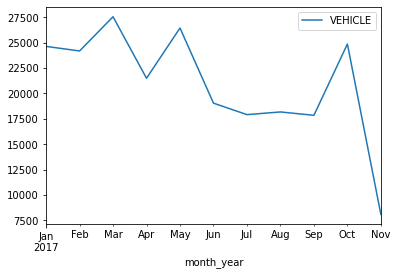

In [106]:
site_by_month.groupby('month_year')['VEHICLE'].median().reset_index().plot(x='month_year', y='VEHICLE')

In [102]:
set(pd.to_datetime(dfs['DATE'],format='%d/%m/%Y').unique())

{numpy.datetime64('2016-03-24T00:00:00.000000000'),
 numpy.datetime64('2016-03-25T00:00:00.000000000'),
 numpy.datetime64('2016-03-26T00:00:00.000000000'),
 numpy.datetime64('2016-03-27T00:00:00.000000000'),
 numpy.datetime64('2016-03-28T00:00:00.000000000'),
 numpy.datetime64('2016-03-29T00:00:00.000000000'),
 numpy.datetime64('2016-03-30T00:00:00.000000000'),
 numpy.datetime64('2016-03-31T00:00:00.000000000'),
 numpy.datetime64('2016-04-01T00:00:00.000000000'),
 numpy.datetime64('2016-04-02T00:00:00.000000000'),
 numpy.datetime64('2016-04-03T00:00:00.000000000'),
 numpy.datetime64('2016-04-04T00:00:00.000000000'),
 numpy.datetime64('2016-04-05T00:00:00.000000000'),
 numpy.datetime64('2016-04-06T00:00:00.000000000'),
 numpy.datetime64('2016-04-07T00:00:00.000000000'),
 numpy.datetime64('2016-04-08T00:00:00.000000000'),
 numpy.datetime64('2016-04-09T00:00:00.000000000'),
 numpy.datetime64('2016-04-10T00:00:00.000000000'),
 numpy.datetime64('2016-04-11T00:00:00.000000000'),
 numpy.datet

In [ ]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(df, locations="iso_alpha",
                     size="pop", # size of markers, "pop" is one of the columns of gapminder
                     )
fig.show()